<a href="https://colab.research.google.com/github/bk62/deep-learning-notebooks/blob/main/generative_deep_learning/02_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[-1. Dataset: Fashion MNIST](#updateTitle=true&folderId=1mwghr2cgAwLd91FL_Ep6CoG2qkkpYyUK&scrollTo=0eupH1EQIwLd)

>[Encoder](#updateTitle=true&folderId=1mwghr2cgAwLd91FL_Ep6CoG2qkkpYyUK&scrollTo=0LmojdNNI8nh)

>[Decoder](#updateTitle=true&folderId=1mwghr2cgAwLd91FL_Ep6CoG2qkkpYyUK&scrollTo=Krpfa4pMQ644)

>[Autoencoder](#updateTitle=true&folderId=1mwghr2cgAwLd91FL_Ep6CoG2qkkpYyUK&scrollTo=P4EuCQsbTz3K)

>[Training](#updateTitle=true&folderId=1mwghr2cgAwLd91FL_Ep6CoG2qkkpYyUK&scrollTo=FgDEbKPwUZVX)

>[Reconstruction](#updateTitle=true&folderId=1mwghr2cgAwLd91FL_Ep6CoG2qkkpYyUK&scrollTo=wIPOMotzei4t)



# -1. Dataset: Fashion MNIST

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms.v2 import Pad, Compose

%matplotlib inline
from matplotlib import pyplot as plt

Resize from 28x28 to 32x32 for simpler input sizes through the conv layers

In [2]:
transforms = Compose([
    ToTensor(),  Pad(padding=(2, 2, 2, 2), fill=0, padding_mode="constant"),
])

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms
)

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"X device: {X.device}, y device {y.device}")
    break

X, y = X.to(device), y.to(device)
X.device, y.device

Shape of X [N, C, H, W]: torch.Size([128, 1, 32, 32])
Shape of y: torch.Size([128]) torch.int64
X device: cpu, y device cpu


(device(type='cuda', index=0), device(type='cuda', index=0))

# 1. Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self, n):
      super().__init__()
      self.stack = nn.Sequential(
          # Note: need padding=1 to ensure dimensions get halfed every time
          # (i.e. 32 -> 16 and not 32 -> 15)
          # See h, w formulas here: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
          # Conv 1
          # 32x32 1ch -> 16x16 32ch
          nn.Conv2d(1, 32, 3, 2, padding=1),
          nn.ReLU(),

          # Conv 2
          # -> 8x8 64ch
          nn.Conv2d(32, 64, 3, 2, padding=1),
          nn.ReLU(),

          # Conv 3
          # -> 4x4 128ch
          nn.Conv2d(64, 128, 3, 2, padding=1),
          nn.ReLU(),

          # Flatten
          # 4*4 128ch -> 2048
          nn.Flatten(),

          # Output layer
          # 2048 -> 2d
          nn.Linear(n//8 * n//8 * 128, 2),
      )

    def forward(self, x):
      x = self.stack(x)
      # flatten
      x = x.view(-1, 2)
      return x

enc = Encoder(32).to(device)
print(enc)

total_params = 0
for name, params in enc.named_parameters():
  print(name, params.numel())
  total_params += params.numel()
print(f"Total params: {total_params}")

Encoder(
  (stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2048, out_features=2, bias=True)
  )
)
stack.0.weight 288
stack.0.bias 32
stack.2.weight 18432
stack.2.bias 64
stack.4.weight 73728
stack.4.bias 128
stack.7.weight 4096
stack.7.bias 2
Total params: 96770


In [6]:
x = X[0:1]
y1 = enc(x)
x.shape, y1.shape

(torch.Size([1, 1, 32, 32]), torch.Size([1, 2]))

In [7]:
x.device, y1.device

(device(type='cuda', index=0), device(type='cuda', index=0))

# 2. Decoder

In [10]:
class Decoder(nn.Module):
  def __init__(self, n):
    super().__init__()

    # Input layer
    # 2 -> 2048
    self.input = nn.Linear(2, n//8 * n//8 * 128)

    # Reshape required (see forward)
    # 2048 -> 4x4 128ch

    # Stack
    self.stack = nn.Sequential(
        # Note: padding=1, output_padding=1 added to ensure doubling of dimensions
        # See https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        # E.g.
        # p = 1
        # d = 1
        # o = 1
        # k = 3
        # Then, H = (4 - 1) * 2 - 2 * p + d * (k - 1) + o + 1

        # ConvT 1
        # 4x4 128ch -> 8x8 128ch
        nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),

        # ConvT 2
        # -> 16x16 64ch
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),

        # ConvT 3
        # -> 32x32 32ch
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),

        # Output layer:
        # Conv 1
        # -> 32x32 1ch
        nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid(),

    )

  def forward(self, x):
    x = self.input(x)
    # batch size, # channels, d1, d2
    x = x.view(-1, 128, 4, 4)
    x = self.stack(x)
    return x


dec = Decoder(32).to(device)
print(dec)

total_params = 0
for name, params in dec.named_parameters():
  print(name, params.numel())
  total_params += params.numel()
print(f"Total params: {total_params}")

Decoder(
  (input): Linear(in_features=2, out_features=2048, bias=True)
  (stack): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)
input.weight 4096
input.bias 2048
stack.0.weight 147456
stack.0.bias 128
stack.2.weight 73728
stack.2.bias 64
stack.4.weight 18432
stack.4.bias 32
stack.6.weight 288
stack.6.bias 1
Total params: 246273


In [11]:
z = dec(y1)
y1.shape, z.shape

(torch.Size([1, 2]), torch.Size([1, 1, 32, 32]))

# 3. Autoencoder

In [12]:
class Autoencoder(nn.Module):
  def __init__(self, n):
    super().__init__()

    self.encoder = Encoder(n)
    self.decoder = Decoder(n)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = Autoencoder(32).to(device)
print(autoencoder)

total_params = 0
for name, params in autoencoder.named_parameters():
  print(name, params.numel())
  total_params += params.numel()
print(f"Total params: {total_params}")

Autoencoder(
  (encoder): Encoder(
    (stack): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=2048, out_features=2, bias=True)
    )
  )
  (decoder): Decoder(
    (input): Linear(in_features=2, out_features=2048, bias=True)
    (stack): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(32, 1, kernel_size=(3, 3

In [13]:
x = X[0:1].to(device)
z = autoencoder(X[0:1])
x.shape, z.shape

(torch.Size([1, 1, 32, 32]), torch.Size([1, 1, 32, 32]))

# 4. Training

In [14]:
loss = nn.BCELoss()
opt = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def rmse_metric(preds, target ):
    loss = torch.sum(torch.square(preds - target) , axis= 1)/(preds.size()[1])
    loss = torch.sum(loss)/loss.shape[0]
    return loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, rmse = 0, 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
            rmse += rmse_metric(pred, X).item()
    test_loss /= num_batches
    rmse /= size
    print(f"Test Error: \n Avg RMSE: {rmse:>8f}, Avg loss: {test_loss:>8f} \n")

In [16]:
loss(z, x)

tensor(0.6913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [17]:
rmse_metric(z, x)

tensor(202.7198, device='cuda:0', grad_fn=<DivBackward0>)

In [18]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, autoencoder, loss, opt)
    test(test_dataloader, autoencoder, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.691807  [  128/60000]
loss: 0.304083  [12928/60000]
loss: 0.268216  [25728/60000]
loss: 0.262430  [38528/60000]
loss: 0.266725  [51328/60000]
Test Error: 
 Avg RMSE: 0.207879, Avg loss: 0.260670 

Epoch 2
-------------------------------
loss: 0.253650  [  128/60000]
loss: 0.258263  [12928/60000]
loss: 0.251559  [25728/60000]
loss: 0.254153  [38528/60000]
loss: 0.261890  [51328/60000]
Test Error: 
 Avg RMSE: 0.195116, Avg loss: 0.256235 

Epoch 3
-------------------------------
loss: 0.250183  [  128/60000]
loss: 0.254005  [12928/60000]
loss: 0.247307  [25728/60000]
loss: 0.250482  [38528/60000]
loss: 0.258717  [51328/60000]
Test Error: 
 Avg RMSE: 0.188586, Avg loss: 0.253877 

Epoch 4
-------------------------------
loss: 0.247356  [  128/60000]
loss: 0.251384  [12928/60000]
loss: 0.245198  [25728/60000]
loss: 0.248277  [38528/60000]
loss: 0.256669  [51328/60000]
Test Error: 
 Avg RMSE: 0.184781, Avg loss: 0.252410 

Epoch 5
------------

# 6. Reconstruction

In [19]:
for (X_test, y_test) in test_dataloader:
  break

In [20]:
X_test.shape

torch.Size([128, 1, 32, 32])

In [21]:
reconstructed = autoencoder(X_test.to(device))

In [22]:
reconstructed.shape

torch.Size([128, 1, 32, 32])

In [23]:
reconstructed = reconstructed.to("cpu").detach()

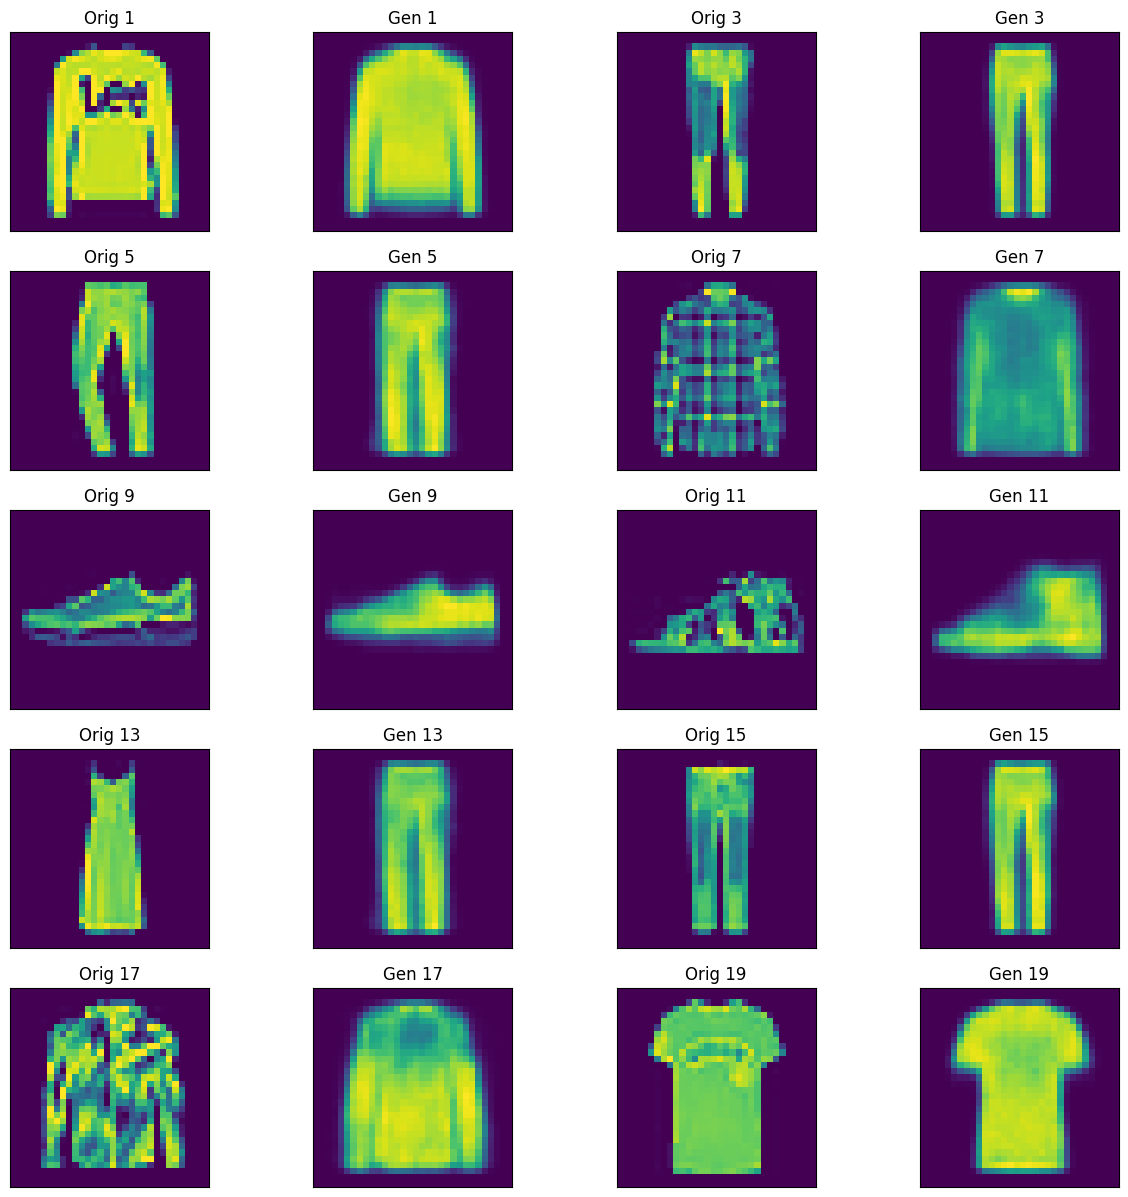

In [35]:
fig = plt.figure(figsize=(15, 15))
for idx in torch.arange(1, 20, 2):
    ix = idx.item()
    ax = fig.add_subplot(5, 4, ix, xticks=[], yticks=[])
    ax.set_title(f"Orig {ix}")
    ax.imshow(torch.squeeze(X_test[idx]))
    ax = fig.add_subplot(5, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(reconstructed[idx]))
    ax.set_title(f"Gen {ix}")

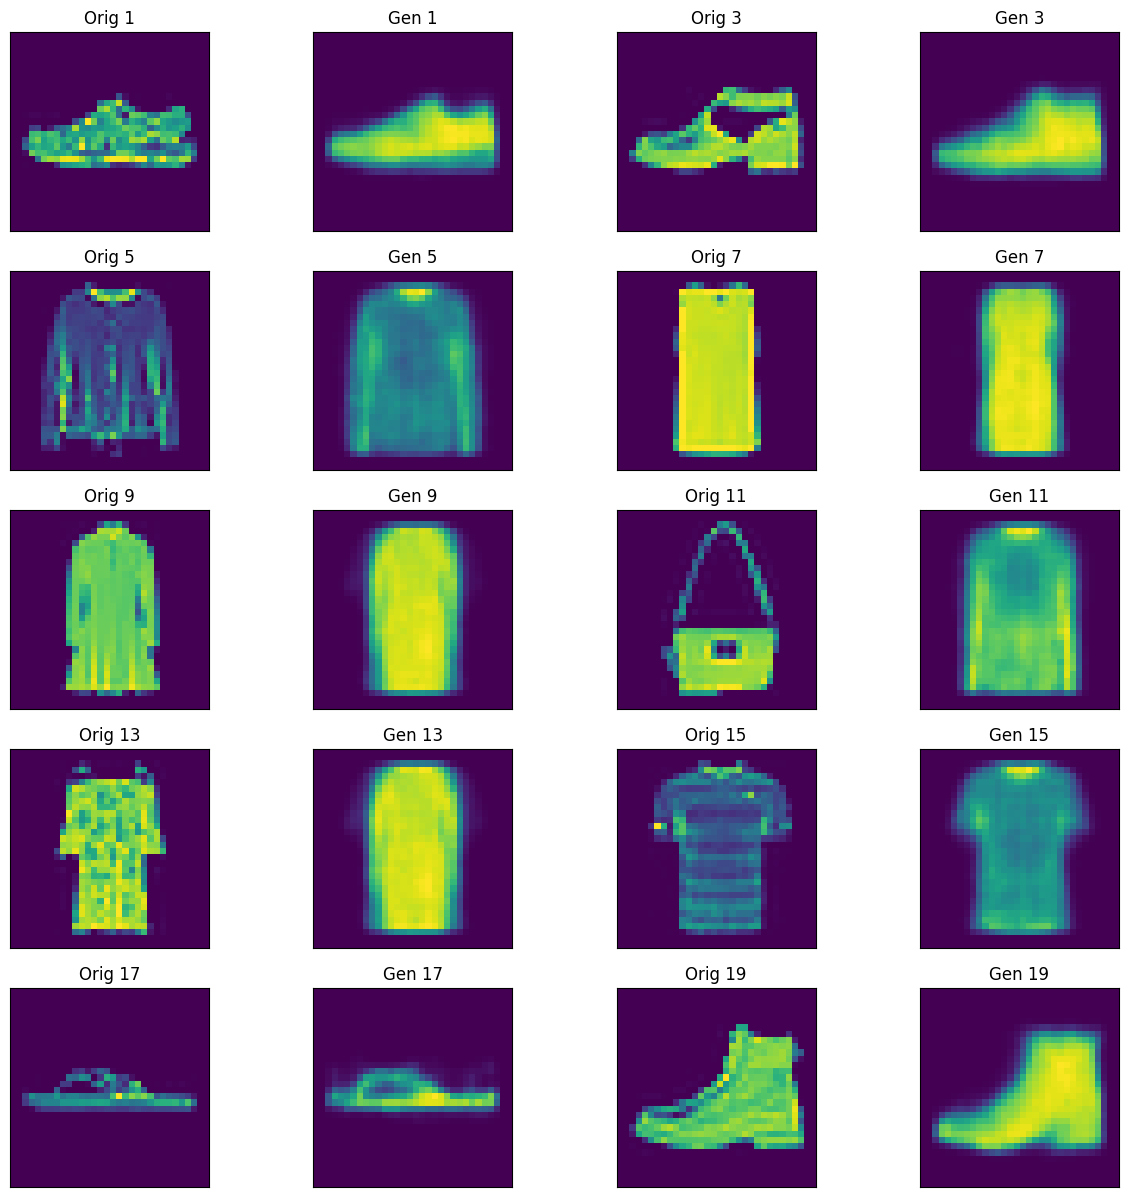

In [36]:
fig = plt.figure(figsize=(15, 15))
for idx in torch.arange(1 + 20, 20 + 20, 2):
    ix = idx.item() - 20
    ax = fig.add_subplot(5, 4, ix, xticks=[], yticks=[])
    ax.set_title(f"Orig {ix}")
    ax.imshow(torch.squeeze(X_test[idx]))
    ax = fig.add_subplot(5, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(reconstructed[idx]))
    ax.set_title(f"Gen {ix}")

# 7. Visualize latent space

In [26]:
embeddings = autoencoder.encoder(X_test.to(device)).to("cpu").detach()

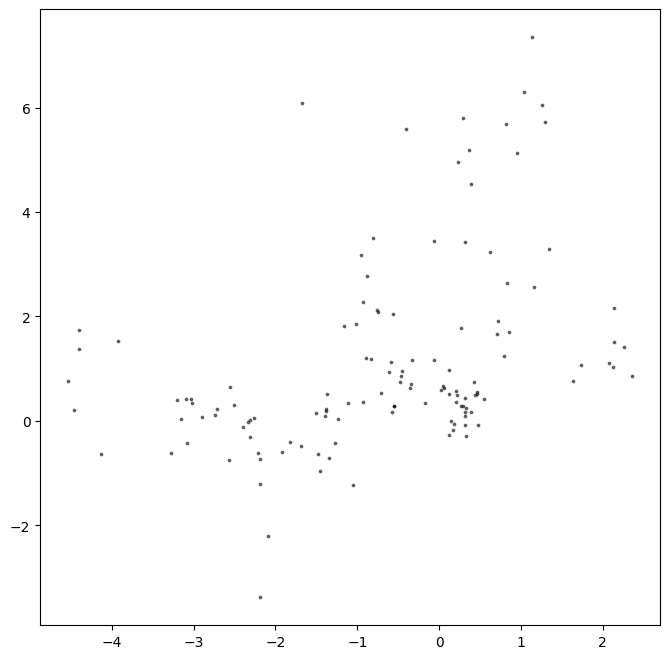

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [43]:
mins, maxs = torch.min(embeddings, 0).values, torch.max(embeddings, 0).values

In [52]:
sample = (mins - maxs) * torch.randn((18, 2)) + maxs
recons = autoencoder.decoder(sample.to(device))

In [53]:
recons.shape

torch.Size([18, 1, 32, 32])

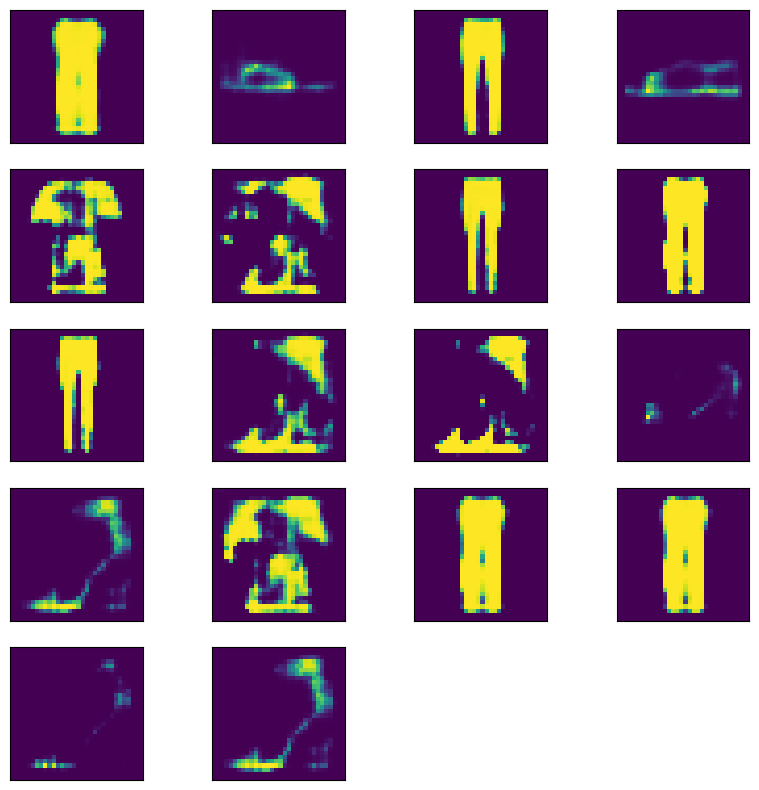

In [58]:
n = recons.shape[0]
recons = recons.to("cpu").detach()

fig = plt.figure(figsize=(10, 10))
for idx in torch.arange(n):
    ix = idx.item()
    ax = fig.add_subplot(n//4 + 1, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(recons[idx]))